In [19]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
pd.options.mode.chained_assignment = None

In [20]:
AMS_DATA_BASE_DIR = Path("/home/rico/Documents/thesis/eda/data/Amsterdam/")
CBS_DATA_BASE_DIR = Path("/home/rico/Documents/thesis/eda/data/CBS/")

In [21]:
ams_neighborhoods = gpd.read_file(AMS_DATA_BASE_DIR.joinpath('ams-neighbourhoods.geojson'))

In [22]:
ams_neighborhoods['centroid'] = gpd.points_from_xy(ams_neighborhoods.cent_x, ams_neighborhoods.cent_y, crs='EPSG:4326')
ams_neighborhoods['res_centroid'] = gpd.points_from_xy(ams_neighborhoods.res_cent_x, ams_neighborhoods.res_cent_y, crs='EPSG:4326')
# Places without residential buildings have no residential centroids. Find them and assign to them the geographical centroid.
ams_neighborhoods.loc[ams_neighborhoods['res_cent_x'].isna(), 'res_centroid'] = ams_neighborhoods[ams_neighborhoods['res_cent_x'].isna()]['centroid']
ams_neighborhoods = ams_neighborhoods.drop(columns=['res_cent_x', 'res_cent_y', 'cent_x', 'cent_y'])

<AxesSubplot:>

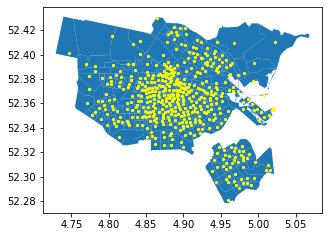

In [23]:
base = ams_neighborhoods.plot(figsize=(5,5))
ams_neighborhoods.res_centroid.plot(ax=base, color='yellow', markersize = 5, figsize=(5,5))

In [24]:
kwb_19 = pd.read_excel(CBS_DATA_BASE_DIR.joinpath('kwb-2019.xls'), na_values='.')
kwb_20 = pd.read_excel(CBS_DATA_BASE_DIR.joinpath('kwb-2020.xls'), na_values='.')
kwb_21 = pd.read_excel(CBS_DATA_BASE_DIR.joinpath('kwb-2021.xls'), na_values='.')
metadata_cols = ["gwb_code_10", "gwb_code_8", "regio", "gm_naam", "recs", "gwb_code"]

In [25]:
def kwb_to_float(kwb: pd.DataFrame) -> pd.DataFrame:
    comma_check = kwb.drop(columns=metadata_cols).apply(
        lambda x: x.str.contains(',').any() if x.dtype == object else False, axis=0)
    cs_floats = comma_check[comma_check == True]
    cs_float_cols = cs_floats.index.to_list()
    kwb[cs_float_cols] = kwb[cs_float_cols].apply(lambda x: x.str.replace(',', '.'), axis=0).astype(np.float64)
    return kwb


kwb_19 = kwb_to_float(kwb_19)
kwb_20 = kwb_to_float(kwb_20)
kwb_21 = kwb_to_float(kwb_21)

# Drop all Buurten that have 0 inhabitants
kwb_19 = kwb_19[kwb_19.a_inw!=0]
kwb_20 = kwb_20[kwb_20.a_inw!=0]
kwb_21 = kwb_21[kwb_21.a_inw!=0]

In [26]:
def kwb_merge_ams_neighborhoods(kwb: pd.DataFrame, ams_neighborhoods: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    kwb['BU_CODE'] = kwb['gwb_code']
    kwb = kwb.drop(columns=metadata_cols)
    ams_neighborhoods = gpd.pd.merge(ams_neighborhoods, kwb, on='BU_CODE')
    return ams_neighborhoods


kwb_19_ams_neighborhoods = kwb_merge_ams_neighborhoods(kwb_19, ams_neighborhoods)
kwb_20_ams_neighborhoods = kwb_merge_ams_neighborhoods(kwb_20, ams_neighborhoods)
kwb_21_ams_neighborhoods = kwb_merge_ams_neighborhoods(kwb_21, ams_neighborhoods)

assert kwb_19_ams_neighborhoods.columns.tolist() == kwb_20_ams_neighborhoods.columns.tolist() == kwb_21_ams_neighborhoods.columns.tolist()

In [ ]:
# Fill NaNs
def inverse_dist_weighted_average(weights, values):
    return sum([(1/weight) * value / sum(1/weights) for weight, value in zip(weights, values)])

for kwb_ams_nhs in tqdm([kwb_19_ams_neighborhoods, kwb_20_ams_neighborhoods, kwb_21_ams_neighborhoods], position=0):
    for col in tqdm(kwb_ams_nhs.columns, position=1, leave=False):
        if kwb_ams_nhs[col].hasnans:
            entries = kwb_ams_nhs[kwb_ams_nhs[col].isna()]
            entries.res_centroid = entries.res_centroid.to_crs('epsg:32631')
            for i, entry in entries.iterrows():
                point = entry.res_centroid
                non_nan_areas = kwb_ams_nhs[~kwb_ams_nhs[col].isna()]
                distances = non_nan_areas.res_centroid.to_crs('epsg:32631').distance(point).sort_values()
                closest_distances_idxs = distances.index[:3]
                closest_distances = distances.loc[closest_distances_idxs].values
                closest_entries = non_nan_areas.loc[closest_distances_idxs]
                interpolated_nan_value = inverse_dist_weighted_average(closest_distances, closest_entries[col].values)
                kwb_ams_nhs.loc[entry.name, col] = interpolated_nan_value


  0%|          | 0/118 [00:00<?, ?it/s]/home/rico/anaconda3/envs/thesis/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/rico/anaconda3/envs/thesis/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)

 30%|██▉       | 35/118 [00:00<00:00, 193.77it/s]/home/rico/anaconda3/envs/thesis/lib/python3.9/site-packages/geopandas/geodatafra

In [10]:
def check_has_any_na(gdf: gpd.GeoDataFrame) -> bool:
    return gdf.apply(lambda x: x.isna(), axis=1).any(axis=0).any()

if not any([check_has_any_na(gdf) for gdf in [kwb_19_ams_neighborhoods, kwb_20_ams_neighborhoods, kwb_21_ams_neighborhoods]]):
    print("Saving files")
    CLEANED_DIR = AMS_DATA_BASE_DIR.joinpath('cleaned_neighbourhood_data')

    if not os.path.exists(CLEANED_DIR):
        os.mkdir(CLEANED_DIR)

    kwb_19_ams_neighborhoods.to_parquet(AMS_DATA_BASE_DIR.joinpath(CLEANED_DIR.joinpath('kwb_19_ams_neighborhoods.parquet')))
    kwb_20_ams_neighborhoods.to_parquet(AMS_DATA_BASE_DIR.joinpath(CLEANED_DIR.joinpath('kwb_20_ams_neighborhoods.parquet')))
    kwb_21_ams_neighborhoods.to_parquet(AMS_DATA_BASE_DIR.joinpath(CLEANED_DIR.joinpath('kwb_21_ams_neighborhoods.parquet')))
else:
    print("Some GeoDataFrames still have NaNs -> won't save them")

Some GeoDataFrames still have NaNs -> won't save them


# Experimentation

In [11]:
kwb_ams_nhs = kwb_19_ams_neighborhoods
col = 'p_hh_li'
point = kwb_ams_nhs.res_centroid[kwb_19_ams_neighborhoods[col].isna()].to_crs('epsg:32631').iloc[0]
non_nan_areas = kwb_ams_nhs[~kwb_ams_nhs[col].isna()]
distances = non_nan_areas.res_centroid.to_crs('epsg:32631').distance(point).sort_values()
closest_distances_idxs = distances.index[:3]
closest_distances = distances.loc[closest_distances_idxs]
closest_entries = non_nan_areas.loc[closest_distances_idxs]

In [ ]:
kwb_ams_nhs.res_centroid[kwb_19_ams_neighborhoods[col].isna()].to_crs('epsg:32631')

In [13]:
closest_entries[col]*(1/closest_distances)/(1/closest_distances.sum())

7    190.068371
0    166.906043
6    157.624770
dtype: float64

In [14]:
def inverse_dist_weighted_average(weights, values):
    return sum([(1/weight) * value / sum(1/weights) for weight, value in zip(weights, values)])

inverse_dist_weighted_average(np.array([1,2,3]),np.array([10,20,30]))

16.363636363636367

(5804000.0, 5805700.0)

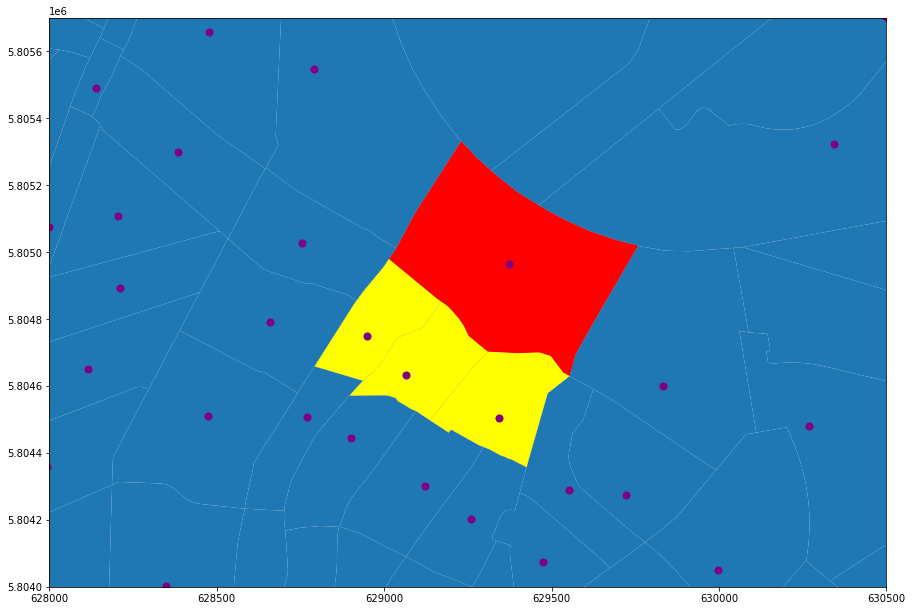

In [38]:
base = kwb_19_ams_neighborhoods.to_crs('epsg:32631').plot(figsize=(15,15))
base = kwb_ams_nhs.iloc[[5]].to_crs('epsg:32631').plot(ax=base, color='red', figsize=(15,15))
base = kwb_ams_nhs.iloc[closest_distances_idxs].to_crs('epsg:32631').plot(ax=base, color='yellow', figsize=(15,15))
ax = kwb_19_ams_neighborhoods.res_centroid.to_crs('epsg:32631').plot(ax=base, color='purple', markersize = 50, figsize=(15,15))

ax.set_xlim(6.28e5,6.305e5)
ax.set_ylim(5.804e6, 5.8057e6)

/home/rico/anaconda3/envs/thesis/lib/python3.9/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<AxesSubplot:>

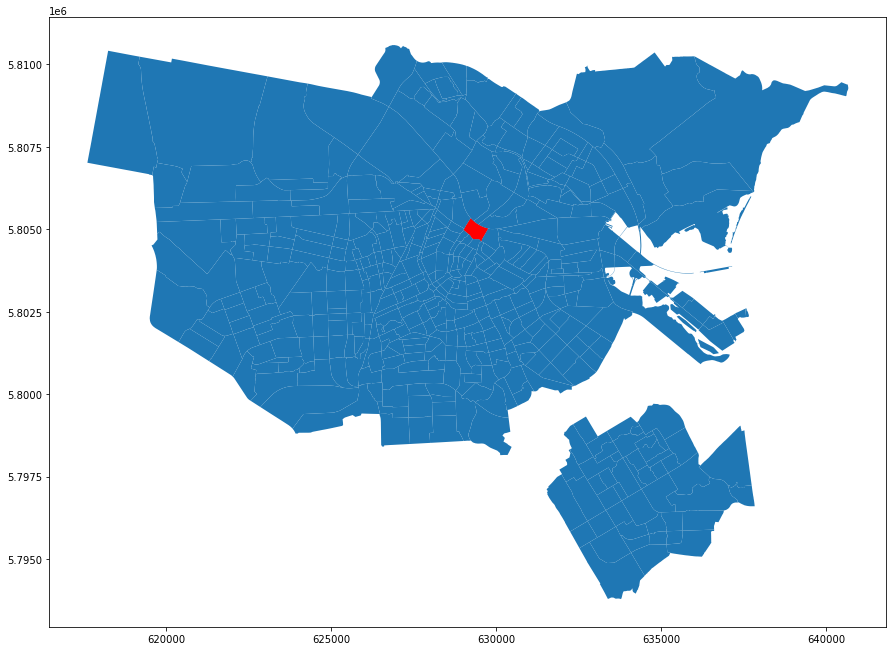

In [40]:
base = kwb_19_ams_neighborhoods.to_crs('epsg:32631').plot(figsize=(15,15))
base = kwb_ams_nhs.iloc[[5]].to_crs('epsg:32631').plot(ax=base, color='red', figsize=(15,15))
base = kwb_19_ams_neighborhoods[kwb_19_ams_neighborhoods[col].isna()].to_crs('epsg:32631').plot(ax=base, color='yellow', figsize=(15,15))